# Information Retrieval

In [1]:
import ParserCACM
import TextRepresenter
import indexation
import modeles
from query import QueryParserCACM
import evaluation
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import operator
# Auto reload the imported modules when running cells
%load_ext autoreload 
%autoreload 2

""" Some info to remember when testing:
- Query 10 is about parallel computation
- Doc 46 is about parallelism too
"""

# Constants:
srcFolder = "cacm/" 
srcFile = "cacm.txt"
qryFile = "cacm.qry"
relFile = "cacm.rel"
gendata = "gendata" #output folder
indexName = "cacm"

cacm_txt = os.path.join(srcFolder, srcFile)
cacm_qry = os.path.join(srcFolder, qryFile)
cacm_rel = os.path.join(srcFolder, relFile)

##  Indexing:

In [2]:
# Construct the index:
idx = indexation.Index(indexName, gendata)
stemmer = TextRepresenter.PorterStemmer()
parser = ParserCACM.ParserCACM()
idx.indexation(cacm_txt, parser, stemmer, verbose=True)
N_docs = len(idx.getDocsID())
print("Successfully indexed %d documents" % N_docs)

Performing the indexation...
1st pass: build the index...
2nd pass: build the inverted index...
Finished.
Successfully indexed 3204 documents


## Testing precision/recall measure:



###### Testing evaluation.PrecisionRecallMeasure: ###### 
Searching for query # [7, 29, 30]

Query: Query {id=7, txt='I am interested in distributed algorithms - concurrent programs in
which processes communicate and synchronize by using message passing.
Areas of particular interest include fault-tolerance and techniques
for understanding the correctness of these algorithms.
', relevances=[1198, 1338, 1877, 1960, 2150, 2228, 2256, 2280, 2320, 2342, 2376, 2482, 2578, 2597, 2618, 2685, 2700, 2777, 2865, 2866, 2895, 2912, 2941, 3043, 3082, 3128, 3141, 3148]}
Retrieve scores...
This query has 28 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.035714
    2|   2 | 1.000000  |0.071429
    4|   3 | 0.750000  |0.107143
   12|   4 | 0.333333  |0.142857
   13|   5 | 0.384615  |0.178571
   19|   6 | 0.315789  |0.214286
   21|   7 | 0.333333  |0.250000
   31|   8 | 0.258065  |0.285714
   32|   9 | 0.281250  |0.321429
   45|  10 | 0.222222  |0.357143
   49|  11 | 0.224490

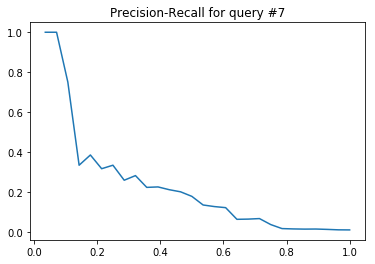

--------------------

Query: Query {id=29, txt='Number-theoretic algorithms, especially involving prime number series,
sieves, and Chinese Remainder theorem.
', relevances=[377, 513, 610, 935, 1094, 1420, 1537, 1538, 1539, 1840, 1841, 1967, 2028, 2089, 2120, 2462, 2927, 2932, 3037]}
Retrieve scores...
This query has 19 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.052632
    2|   2 | 1.000000  |0.105263
    3|   3 | 1.000000  |0.157895
    4|   4 | 1.000000  |0.210526
    5|   5 | 1.000000  |0.263158
    6|   6 | 1.000000  |0.315789
    7|   7 | 1.000000  |0.368421
    8|   8 | 1.000000  |0.421053
   10|   9 | 0.900000  |0.473684
   11|  10 | 0.909091  |0.526316
   12|  11 | 0.916667  |0.578947
   13|  12 | 0.923077  |0.631579
   14|  13 | 0.928571  |0.684211
   15|  14 | 0.933333  |0.736842
   17|  15 | 0.882353  |0.789474
   19|  16 | 0.842105  |0.842105
   39|  17 | 0.435897  |0.894737
  171|  18 | 0.105263  |0.947368
  186|  19 | 0.102151  |1.000000


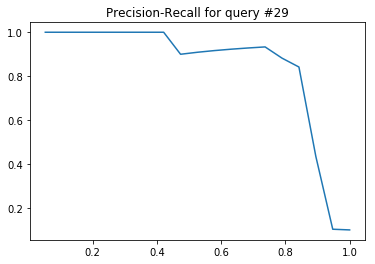

--------------------

Query: Query {id=30, txt='Articles on text formatting systems, including "what you see is what you
get" systems.  Examples: t/nroff, scribe, bravo.
', relevances=[1926, 2486, 2786, 2917]}
Retrieve scores...
This query has 4 relevant results
   i |found| precision | recall
    1|   1 | 1.000000  |0.250000
    6|   2 | 0.333333  |0.500000
   13|   3 | 0.230769  |0.750000
   18|   4 | 0.222222  |1.000000


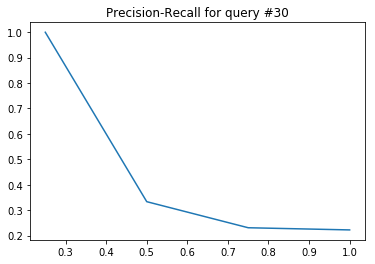

--------------------
Done.


In [3]:
binWeighter = modeles.BinaryWeighter(idx)
tfidfWeighter = modeles.TfidfWeighter(idx)
vect = modeles.Vectoriel(idx, tfidfWeighter)

print("\n###### Testing evaluation.PrecisionRecallMeasure: ###### ")
queryChosen = [7, 29, 30]
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #", queryChosen)
while query is not None :
    if int(query.getID()) in queryChosen:
        print("\nQuery:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        ranking = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, ranking)
        precisRecall = evaluation.PrecisionRecallMeasure(irlist)
        pr = precisRecall.eval(verbose=True, nbLevel=100) # (recall, precision)
        precision = [p for r,p in pr]
        recall = [r for r,p in pr]
        plt.plot(recall, precision)
        plt.title("Precision-Recall for query #"+query.getID())
        plt.show()
        print(20*'-')


    query = qp.nextQuery()
print("Done.")


## Testing average precision:

In [4]:
print("\n###### Testing evaluation.AveragePrecision: ###### ")
queryChosen =[9, 10, 14, 29]#, 25, 26, 27, 42, 43] # lots of relevant results
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for query #",queryChosen, "\n")
while query is not None :
    if int(query.getID()) in queryChosen:
        print("Query:", query)
        queryTxt = stemmer.getTextRepresentation(query.getText())
        print("Retrieve scores...")
        scores = vect.getRanking(queryTxt)
        irlist = evaluation.IRList(query, scores)
        average_measure = evaluation.AveragePrecision(irlist)
        print("Evaluate the scores.")
        average_prec = average_measure.eval(verbose=True)
        print("Average precision: %f" % average_prec)
        print(20*'-')

    query = qp.nextQuery()



###### Testing evaluation.AveragePrecision: ###### 
Searching for query # [9, 10, 14, 29] 

Query: Query {id=9, txt='Security considerations in local networks, network operating systems,
and distributed systems.
', relevances=[2372, 2632, 2870, 2876, 3068, 3111, 3128, 3158, 3177]}
Retrieve scores...
Evaluate the scores.
This query has 9 relevant results
   i |found| precision
    1|   1 | 1.000000
    2|   2 | 1.000000
    3|   3 | 1.000000
    4|   4 | 1.000000
    6|   5 | 0.833333
   33|   6 | 0.181818
   71|   7 | 0.098592
  111|   8 | 0.072072
  311|   9 | 0.028939
Average precision: 0.579417
--------------------
Query: Query {id=10, txt='Parallel languages; languages for parallel computation
', relevances=[46, 141, 392, 950, 1158, 1198, 1262, 1380, 1471, 1601, 1613, 1747, 1795, 1811, 2060, 2150, 2256, 2289, 2342, 2376, 2433, 2618, 2664, 2685, 2700, 2714, 2777, 2785, 2851, 2895, 2896, 2912, 3039, 3075, 3156]}
Retrieve scores...
Evaluate the scores.
This query has 35 relevant resu

## Testing EvalIRModel:

In [5]:
print("\n###### Testing evaluation.EvalIRModel: ###### ")
queryChosen = np.random.randint(1, 64, size=10)
#queryChosen =[7, 10, 14]#, 25, 26, 27, 42, 43] # lots of relevant results
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found queries")
irmodels = {"vectoriel_tfidf": modeles.Vectoriel(idx, tfidfWeighter),
            "vectoriel_bw": modeles.Vectoriel(idx, binWeighter)
           }
measures = {"averagePrecision": evaluation.AveragePrecision}
eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
print("Calling eval()...")
print(eval_model.eval(verbose=False))
print("Done.")



###### Testing evaluation.EvalIRModel: ###### 
Searching for queries # [ 9 46 29 18  6 22 22  4 34 32] ...
Found queries
Calling eval()...
{('vectoriel_tfidf', 'averagePrecision'): (0.3663958301268338, 0.30173236250854613), ('vectoriel_bw', 'averagePrecision'): (0.27421307160375885, 0.28081803596094912)}
Done.


## Comparison of language models:

In [6]:
from sklearn.model_selection import train_test_split

# Searching queries:
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found all queries")

q_train, q_test = train_test_split(queries)

# Train models, find best parameters.
unigram_params_grid = {'index':[idx], 'regularization':np.linspace(0,1, 20, endpoint=False)}

#c = dict_combinations(params_grid)
#print("comb: ",c)

best_unigram_params = {'index':idx, 'regularization':0.36842105263157893}
#best_unigram_params = evaluation.gridsearch(modeles.UnigramLanguage, unigram_params_grid, 
#                 q_train, evaluation.AveragePrecision, verbose=1)
print("Best unigram params:", best_unigram_params)

Searching for queries # [ 9 46 29 18  6 22 22  4 34 32] ...
Found all queries
Best unigram params: {'regularization': 0.3684210526315789, 'index': <indexation.Index object at 0x7fd3344ede48>}


In [7]:
okapi_params_grid = {'index':[idx], 'k':np.linspace(1, 2, 10), 'b':np.linspace(0,2,10)}

best_okapi_params = {'index':idx, 'k': 1.1111111111111112, 'b': 0.44444444444444442}
#best_okapi_params = evaluation.gridsearch(modeles.Okapi, okapi_params_grid, 
#             q_train, evaluation.AveragePrecision, verbose=1)

print("Best okapi params:", best_okapi_params)

Best okapi params: {'b': 0.4444444444444444, 'k': 1.1111111111111112, 'index': <indexation.Index object at 0x7fd3344ede48>}


### Execution on the test set:

In [8]:
print("best unigram params:", best_unigram_params)
print("best okapi params:", best_okapi_params)

irmodels = {'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)}

eval_models = evaluation.EvalIRModel(q_test, irmodels, {'measure':evaluation.AveragePrecision})
scores = eval_models.eval(verbose=True)
print(scores)

best unigram params: {'regularization': 0.3684210526315789, 'index': <indexation.Index object at 0x7fd3344ede48>}
best okapi params: {'b': 0.4444444444444444, 'k': 1.1111111111111112, 'index': <indexation.Index object at 0x7fd3344ede48>}
IRModel: unigram
Measure: measure
(0.13844408879186273, 0.10858060707035216)
IRModel: okapi
Measure: measure
(0.26030953755208913, 0.25164154095354219)
{('unigram', 'measure'): (0.13844408879186273, 0.10858060707035216), ('okapi', 'measure'): (0.26030953755208913, 0.25164154095354219)}


In [9]:
print("\n###### Comparison of different models: ###### ")
queryChosen = np.random.randint(1, 64, size=10)
queries = []
qp = QueryParserCACM(cacm_qry, cacm_rel)
query = qp.nextQuery()
print("Searching for queries #",queryChosen, "...")
while query is not None :
    if int(query.getID()) in queryChosen:
        queries.append(query)
    query = qp.nextQuery()
print("Found queries")
irmodels = {"vectoriel_tfidf": modeles.Vectoriel(idx, tfidfWeighter),
            "vectoriel_bw": modeles.Vectoriel(idx, binWeighter),
            'unigram':modeles.UnigramLanguage(**best_unigram_params),
            'okapi':modeles.Okapi(**best_okapi_params)
           }
measures = {"averagePrecision": evaluation.AveragePrecision}
eval_model = evaluation.EvalIRModel(queries, irmodels, measures)
print("Calling eval()...")
print(eval_model.eval(verbose=False))
print("Done.")



###### Comparison of different models: ###### 
Searching for queries # [12  2 32  5  8 54 33 43 31 41] ...
Found queries
Calling eval()...
{('okapi', 'averagePrecision'): (0.243672340600396, 0.20553749872172411), ('vectoriel_tfidf', 'averagePrecision'): (0.20331324259378994, 0.17270143278292813), ('vectoriel_bw', 'averagePrecision'): (0.13964320399619964, 0.12992065571580211), ('unigram', 'averagePrecision'): (0.25790542552341894, 0.20846090566468548)}
Done.
